## Gaussian Processes
---
#### Sean McLaughlin
##### BRR Bread 7/12/2023

##### What is a GP?

A Gaussian Process (GP) is equal parts elegant statistical construct and  supervised machine learning algorithm. 
Its power comes from its ability to be interpreted in a myriad of ways.

They represent a distribution of functions that have the same covariance structure, enabling them to easily model complex systems with unknown covariance structures. However, this all comes at the cost of pretty brutal space & time complexity. 

##### What is a GP? | I know math.

A GP is a *collection of random variables, any finite number of which have a joint Gaussian distribution.*

In other words a function of a vector **x** is drawn from an *N* dimensional GP, where *N* is the length of **x**.

$$m(\mathbf{x}) = \mathop{{}\mathbb{E}}[f(\mathbf{x})] $$
$$k(\mathbf{x},\mathbf{x}^\intercal ) = \mathop{{}\mathbb{E}}[(f(\mathbf{x}) - m(\mathbf{x}) )(f(\mathbf{x^\intercal}) - m(\mathbf{x^\intercal}) )] $$

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x^\intercal})) $$

In general, we can assume $m(\mathbf{x}) = \vec{0}$ (and add it back in later if we want).

Then, our entire GP is determined by the kernel $k$. The kernel is a function that essentially answers the question "How correlated are two points $x_1$ and $x_2$. Kernels can be dependent on a particular point in space, osciallte, or do lots of crazy stuff (so long as they always produce a PSD covariance matrix). However, the most common one (and one we'll focus on) is a Gaussian kernel. 

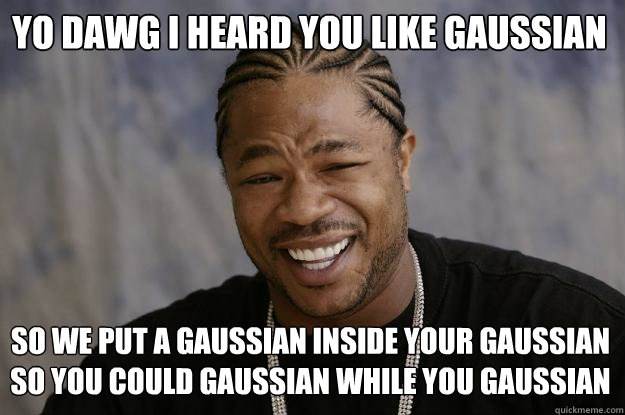

In [1]:
from IPython.display import Image
Image("./xibit.jpg")

$$k(x_1, x_2) = \exp\left(\frac{-|x_1-x_2|^2}{ l}\right) $$

The correlation between two points is only dependent on their distance, and it falls off with scale length $l$. We evaluate the kernel at each pair of dependent variables to get the covariance matrix.

$$k(x_1, x_2) = K_{1,2}$$

We can sample functions from this sort of unconstrainted GP.

In [2]:
import numpy as np
import george
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

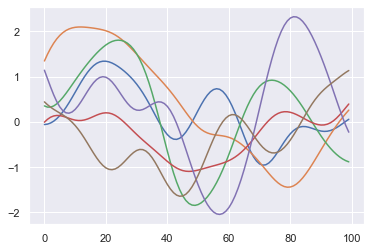

In [3]:
kernel = george.kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernel)

t = gp.sample(np.linspace(0,10,100), 6)
for f in t:
    plt.plot(f)

Changing the scale length changes how "wiggly" it is.

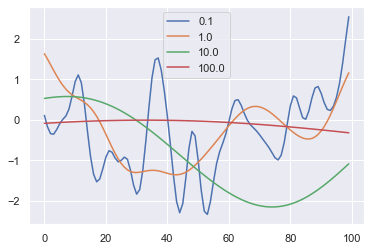

In [4]:
for l in [0.1, 1.0, 10.0, 100.0]:
    kernel = george.kernels.ExpSquaredKernel(l)
    gp = george.GP(kernel) 
    
    plt.plot(gp.sample(np.linspace(0,10,100)), label = l)
    
plt.legend(loc = 'best')
plt.show()

##### How do I make predictions? 

Predictions are made by drawing from the conditional distribution! We measure values of $\mathbf{x}$ and $f(\mathbf{x})$. Then, we can draw samples from the conditional distribution (which is a conditional Normal) at values were interested in, $\mathbf{x_*}$. Skipping the derivation:


$$\mathop{{}\mathbb{E}}[f(\mathbf{x_*}) | \mathbf{x_*}, \mathbf{x}, f(\mathbf{x})] = K(\mathbf{x_*}, \mathbf{x}) K^{-1}(\mathbf{x}, \mathbf{x}) f(\mathbf{x}) $$


$$\mathrm{\mathbb{Var}}[f(\mathbf{x_*}) | \mathbf{x_*}, \mathbf{x}, f(\mathbf{x})] = K(\mathbf{x_*},\mathbf{x_*}) - K(\mathbf{x_*}, \mathbf{x}) K^{-1}(\mathbf{x}, \mathbf{x}))K(\mathbf{x}, \mathbf{x_*})  $$

Let's add some data to our above plot. 

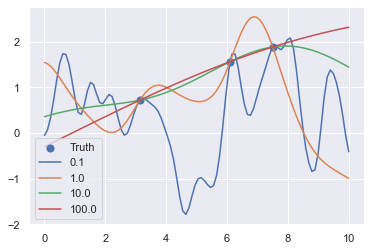

In [5]:
x = np.array([3.14, 6.1, 7.5])
yerr = 0.1
m, b = 0.2, -0.3
y = m*x-b + np.random.randn(x.shape[0])*yerr
plt.scatter(x,y, s = 50, color = 'b', label = 'Truth')

for l in [0.1, 1.0, 10.0, 100.0]:
    kernel = george.kernels.ExpSquaredKernel(l)
    gp = george.GP(kernel) 
    gp.compute(x)
    
    plt.plot(np.linspace(0,10,100), gp.sample_conditional(y, np.linspace(0,10,100)), label = l)
    
plt.legend(loc = 'best')

plt.show()

These are samples, but we can view the conditional distribution.

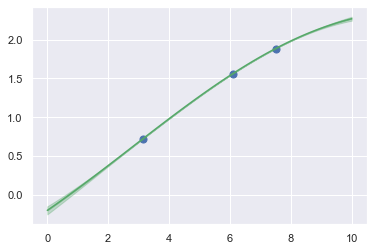

In [6]:
l = 10.0
mu, cov = gp.predict(y,np.linspace(0,10,100) )
err = np.sqrt(np.diag(cov))

plt.scatter(x,y, s = 50, color = 'b', label = 'Truth')

plt.plot(np.linspace(0,10,100), mu, color = 'g')
plt.fill_between(np.linspace(0,10,100), mu, mu+err, color = 'g', alpha = 0.3)
plt.fill_between(np.linspace(0,10,100), mu, mu-err, color = 'g', alpha = 0.3)

plt.show()

We can also add measurement errors to our data points.

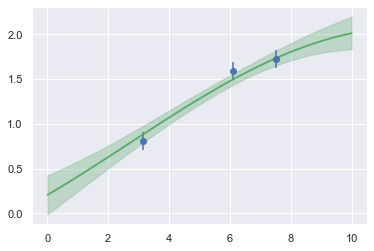

In [7]:
me  = 0.1
measurement_err = np.random.randn(x.shape[0])*me
gp.compute(x, me)
mu, cov = gp.predict(y+measurement_err,np.linspace(0,10,100) )
err = np.sqrt(np.diag(cov))

plt.errorbar(x,y+measurement_err,yerr = np.array([me for i in range(x.shape[0])]),fmt= 'o', color = 'b', label = 'Truth')

plt.plot(np.linspace(0,10,100), mu, color = 'g')
plt.fill_between(np.linspace(0,10,100), mu, mu+err, color = 'g', alpha = 0.3)
plt.fill_between(np.linspace(0,10,100), mu, mu-err, color = 'g', alpha = 0.3)

plt.show()

#### GPs to model correlated noise 
The above example walks through using just a pure GP to fit data. However, because of the handy mean-function properties of GPs, they can be linearly added to any other model and used to model correlated noise in those models. 

The below linked example walks through a simple, physical example using this property.

[Link](https://george.readthedocs.io/en/latest/tutorials/model/)

##### What's the catch?

Notice that in the prediction step, we have to invert the kernel matrix. Considering the kernel matrix has sidelength the same as the number of training points, building a GP is $\mathcal{O}(N^3)$ in time and $\mathcal{O}(N^2)$ in space where N is the number of rows in the dataset. This means GPs can be heavily punished by the curse of dimensionality. This is especially true during optimzation where this inversion has to be performed each optimization step. 

For that reason, there is a considerable amount of work to make GPs more efficient. The primary ways this is done are:
1. Sparse GPs: Using VI to find an optimal forcing subset of *X* to summarize the dataset
2. Kronecker GPs: Leveraging the fact that $(A \otimes B)^{-1} = A^{-1} \otimes B^{-1}$, we can design our sampling space to make the inversion much more efficient. For example, if we had one respondent in every State, Education, Age, and Race bin, we could decompose that large sampling matrix into a product of 4 much smaller vectors, at the cost of having to maintain a rigid sampling space to get those efficiency gains. 

In [20]:
# hyperparameter optimization 
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p, gp):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p, gp):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    return -gp.grad_lnlikelihood(y, quiet=True)


def optimize(gp):
    # Run the optimization routine.
    # Print the initial ln-likelihood.
    print(gp.lnlikelihood(y))
    p0 = gp.get_parameter_vector()
    results = op.minimize(lambda p: nll(p, gp), p0, jac=lambda p: grad_nll(p, gp))

    # Update the kernel and print the final log-likelihood.
    gp.set_parameter_vector(results.x)
    print(gp.lnlikelihood(y))
    print(results.x)
    return gp

-2.760867335716062
-2.760867335716062
[3.35594013]


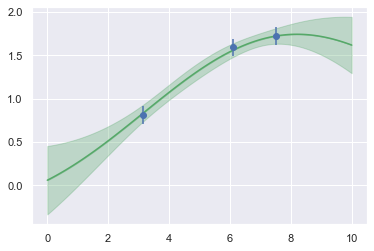

In [21]:
gp = optimize(gp)
gp.recompute()

mu, cov = gp.predict(y+measurement_err,np.linspace(0,10,100) )
err = np.sqrt(np.diag(cov))

plt.errorbar(x,y+measurement_err,yerr = np.array([me for i in range(x.shape[0])]),fmt= 'o', color = 'b', label = 'Truth')

plt.plot(np.linspace(0,10,100), mu, color = 'g')
plt.fill_between(np.linspace(0,10,100), mu, mu+err, color = 'g', alpha = 0.3)
plt.fill_between(np.linspace(0,10,100), mu, mu-err, color = 'g', alpha = 0.3)

plt.show()

#### Kernel Functions
Above we only considered the Squared Exponential Kernel, which is a pretty nice starting point because it assumes points that are closer in space are more correlated than points further away. However we have much more freedom in our choice of kernel - the kernel function just needs to produce a valid PSD matrix. And kernel functions have the property that any linear combination of kernel functions is a kernel function. Below is linked a tour of various common kernel functions.

[Kernel Functions](https://george.readthedocs.io/en/latest/user/kernels/#stationary-kernels)

-4.391592933247872
-1.8956862467268518
[2.11525045 0.41853824]


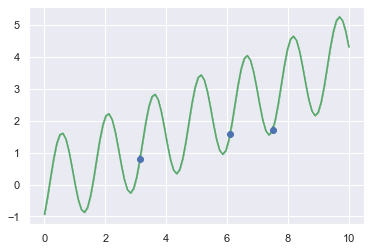

In [30]:
kernel = george.kernels.LinearKernel(0.0, 1) + george.kernels.CosineKernel(0.5)
gp2 = george.GP(kernel)
gp2.compute(x)

gp2 = optimize(gp2)
gp2.recompute()

mu, cov = gp2.predict(y+measurement_err,np.linspace(0,10,100) )
err = np.sqrt(np.diag(cov))

plt.errorbar(x,y+measurement_err,yerr = np.array([me for i in range(x.shape[0])]),fmt= 'o', color = 'b', label = 'Truth')

plt.plot(np.linspace(0,10,100), mu, color = 'g')
plt.fill_between(np.linspace(0,10,100), mu, mu+err, color = 'g', alpha = 0.3)
plt.fill_between(np.linspace(0,10,100), mu, mu-err, color = 'g', alpha = 0.3)

plt.show()

#### Further Reading
[Rasumussen and Williams](https://gaussianprocess.org/gpml/chapters/RW.pdf) Is the most thorough textbook on the subject, and goes into much more of the derivation stuff I've glossed over here. 
[This Visualizer](http://www.infinitecuriosity.org/vizgp/) Can be helpful for developing intuition.